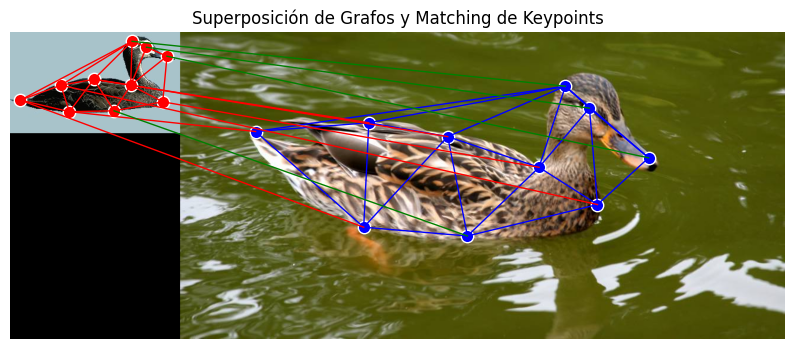

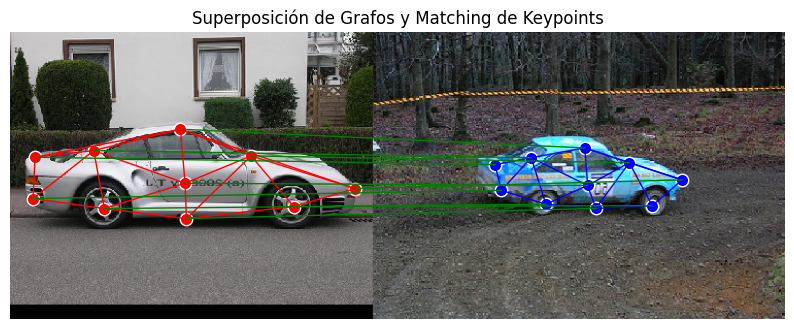

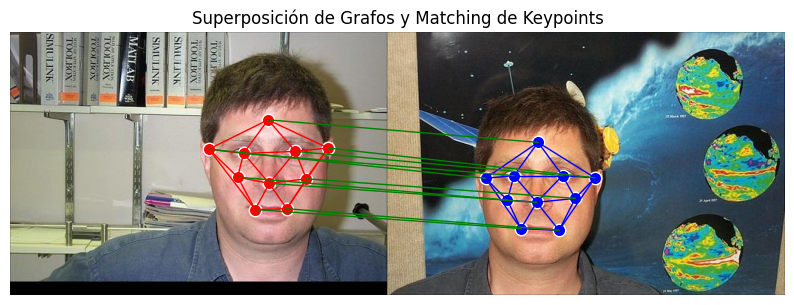

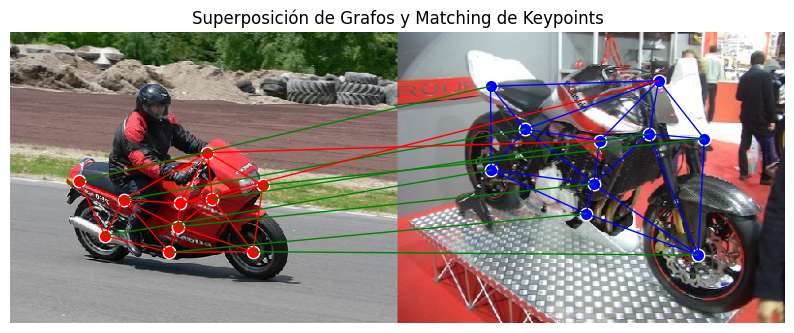

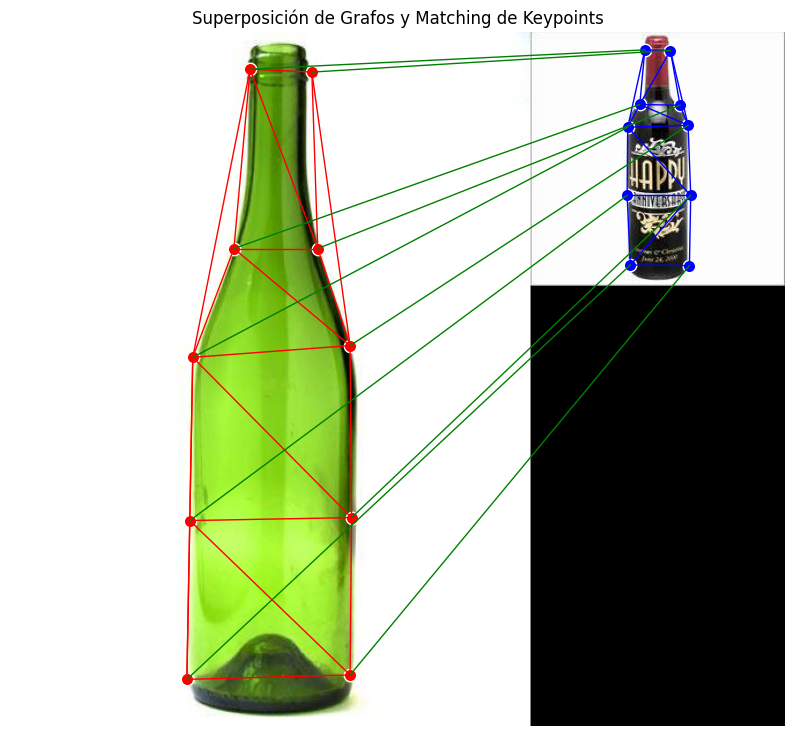

Resultados guardados en resultados_precision.csv


In [18]:
import numpy as np
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, distance
from scipy.optimize import linear_sum_assignment

def load_and_preprocess_images(img_path1, img_path2, mat_path1, mat_path2):
    img1 = np.array(Image.open(img_path1).convert("RGB"))
    img2 = np.array(Image.open(img_path2).convert("RGB"))
    kpts1 = np.array(sio.loadmat(mat_path1)['pts_coord'])
    kpts2 = np.array(sio.loadmat(mat_path2)['pts_coord'])
    return img1, img2, kpts1, kpts2

def delaunay_triangulation(kpts):
    pts = kpts.T
    tri = Delaunay(pts)
    N = pts.shape[0]
    A = np.zeros((N, N))
    for simplex in tri.simplices:
        for i in range(len(simplex)):
            for j in range(i+1, len(simplex)):
                A[simplex[i], simplex[j]] = 1
                A[simplex[j], simplex[i]] = 1
    return A

def simple_spatial_matching(kpts1, kpts2):
    pts1 = kpts1.T
    pts2 = kpts2.T
    cost_matrix = distance.cdist(pts1, pts2, metric='euclidean')
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    matching = np.zeros(cost_matrix.shape, dtype=int)
    matching[row_ind, col_ind] = 1
    return matching

def visualize_combined(img1, img2, kpts1, kpts2, adj_matrix1, adj_matrix2, matching):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    composite_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    composite_img[:h1, :w1, :] = img1
    composite_img[:h2, w1:w1+w2, :] = img2
    
    # Trasladar keypoints de la segunda imagen en X para ajustarse a la nueva posición
    kpts2_shifted = kpts2.copy()
    kpts2_shifted[0, :] += w1
    
    plt.figure(figsize=(10, 10))
    plt.imshow(composite_img)
    
    # Dibujar los grafos de Delaunay en ambas imágenes
    for kpts, adj_matrix, color in zip([kpts1, kpts2_shifted], [adj_matrix1, adj_matrix2], ['r', 'b']):
        N = kpts.shape[1]
        for i in range(N):
            for j in range(i+1, N):
                if adj_matrix[i, j]:
                    plt.plot([kpts[0, i], kpts[0, j]], [kpts[1, i], kpts[1, j]], color+'-', linewidth=1)
        plt.scatter(kpts[0], kpts[1], c=color, edgecolors='w', s=80)
    
    # Dibujar las correspondencias entre keypoints
    row_ind, col_ind = np.where(matching == 1)
    for r, c in zip(row_ind, col_ind):
        x1, y1 = kpts1[:, r]
        x2, y2 = kpts2_shifted[:, c]
        # Si el índice coincide, se considera correcto y se pinta en verde, de lo contrario en rojo.
        if r == c:
            plt.plot([x1, x2], [y1, y2], 'g-', linewidth=1)
        else:
            plt.plot([x1, x2], [y1, y2], 'r-', linewidth=1)
    
    plt.title("Superposición de Grafos y Matching de Keypoints")
    plt.axis('off')
    plt.show()


def evaluate_matching_precision(kpts1, matching):
    """
    Calcula la precisión comparando la coincidencia obtenida con la correspondencia
    ideal (la diagonal de la matriz de matching). Se asume que los puntos clave están
    en el mismo orden en ambas imágenes.
    """
    N = kpts1.shape[1]
    # Se consideran correctas aquellas coincidencias donde el índice de fila coincide con el de columna.
    row_ind, col_ind = np.where(matching == 1)
    correct = np.sum(row_ind == col_ind)
    return correct / N if N != 0 else 0

def compute_precision_for_categories():
    """
    Evalúa la precisión para cada categoría de imagen, generando un CSV con la precisión media
    y la desviación estándar (en este caso, para una sola medida, la desviación es 0).
    """
    import csv

    categories = [
        {
            'name': 'Duck',
            'img1': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Duck/060_0000.png',
            'img2': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Duck/060_0010.png',
            'mat1': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Duck/060_0000.mat',
            'mat2': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Duck/060_0010.mat'
        },
        {
            'name': 'Car',
            'img1': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Car/Cars_000a.png',
            'img2': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Car/Cars_001b.png',
            'mat1': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Car/Cars_000a.mat',
            'mat2': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Car/Cars_001b.mat'
        },
        {
            'name': 'Face',
            'img1': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Face/image_0001.png',
            'img2': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Face/image_0004.png',
            'mat1': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Face/image_0001.mat',
            'mat2': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Face/image_0004.mat'
        },
        {
            'name': 'Motorbike',
            'img1': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Motorbike/Motorbikes_001a.png',
            'img2': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Motorbike/Motorbikes_002a.png',
            'mat1': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Motorbike/Motorbikes_001a.mat',
            'mat2': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Motorbike/Motorbikes_002a.mat'
        },
        {
            'name': 'Winebottle',
            'img1': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Winebottle/246_0001.png',
            'img2': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Winebottle/246_0002.png',
            'mat1': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Winebottle/246_0001.mat',
            'mat2': '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Winebottle/246_0002.mat'
        }
    ]

    results = []

    for cat in categories:
        # Cargar imágenes y keypoints para la categoría actual
        img1, img2, kpts1, kpts2 = load_and_preprocess_images(cat['img1'], cat['img2'], cat['mat1'], cat['mat2'])
        matching = simple_spatial_matching(kpts1, kpts2)
        precision = evaluate_matching_precision(kpts1, matching)
        # Al tener una única medición, la media es la precisión y la desviación estándar es 0.
        results.append({
            'Categoria': cat['name'],
            'Precision media': precision,
            'Desviacion estandar': 0
        })

    # Guardar los resultados en un archivo CSV
    csv_file = 'resultados_precision.csv'
    with open(csv_file, mode='w', newline='') as file:
        fieldnames = ['Categoria', 'Precision media', 'Desviacion estandar']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for row in results:
            writer.writerow(row)

    print(f"Resultados guardados en {csv_file}")
if __name__ == "__main__":
    # Mostrar imágenes de Duck
    duck_img1 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Duck/060_0000.png'
    duck_img2 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Duck/060_0010.png'
    duck_mat1 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Duck/060_0000.mat'
    duck_mat2 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Duck/060_0010.mat'
    
    duck_img1, duck_img2, duck_kpts1, duck_kpts2 = load_and_preprocess_images(duck_img1, duck_img2, duck_mat1, duck_mat2)
    duck_adj1 = delaunay_triangulation(duck_kpts1)
    duck_adj2 = delaunay_triangulation(duck_kpts2)
    duck_matching = simple_spatial_matching(duck_kpts1, duck_kpts2)
    visualize_combined(duck_img1, duck_img2, duck_kpts1, duck_kpts2, duck_adj1, duck_adj2, duck_matching)
    
    # Mostrar imágenes de Car
    car_img1 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Car/Cars_000a.png'
    car_img2 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Car/Cars_001b.png'
    car_mat1 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Car/Cars_000a.mat'
    car_mat2 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Car/Cars_001b.mat'
    
    car_img1, car_img2, car_kpts1, car_kpts2 = load_and_preprocess_images(car_img1, car_img2, car_mat1, car_mat2)
    car_adj1 = delaunay_triangulation(car_kpts1)
    car_adj2 = delaunay_triangulation(car_kpts2)
    car_matching = simple_spatial_matching(car_kpts1, car_kpts2)
    visualize_combined(car_img1, car_img2, car_kpts1, car_kpts2, car_adj1, car_adj2, car_matching)
    
    # Mostrar imágenes de Face
    face_img1 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Face/image_0001.png'
    face_img2 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Face/image_0004.png'
    face_mat1 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Face/image_0001.mat'
    face_mat2 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Face/image_0004.mat'
    
    face_img1, face_img2, face_kpts1, face_kpts2 = load_and_preprocess_images(face_img1, face_img2, face_mat1, face_mat2)
    face_adj1 = delaunay_triangulation(face_kpts1)
    face_adj2 = delaunay_triangulation(face_kpts2)
    face_matching = simple_spatial_matching(face_kpts1, face_kpts2)
    visualize_combined(face_img1, face_img2, face_kpts1, face_kpts2, face_adj1, face_adj2, face_matching)
    
    # Mostrar imágenes de Motorbike
    motorbike_img1 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Motorbike/Motorbikes_001a.png'
    motorbike_img2 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Motorbike/Motorbikes_002a.png'
    motorbike_mat1 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Motorbike/Motorbikes_001a.mat'
    motorbike_mat2 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Motorbike/Motorbikes_002a.mat'
    
    motorbike_img1, motorbike_img2, motorbike_kpts1, motorbike_kpts2 = load_and_preprocess_images(motorbike_img1, motorbike_img2, motorbike_mat1, motorbike_mat2)
    motorbike_adj1 = delaunay_triangulation(motorbike_kpts1)
    motorbike_adj2 = delaunay_triangulation(motorbike_kpts2)
    motorbike_matching = simple_spatial_matching(motorbike_kpts1, motorbike_kpts2)
    visualize_combined(motorbike_img1, motorbike_img2, motorbike_kpts1, motorbike_kpts2, motorbike_adj1, motorbike_adj2, motorbike_matching)
    
    # Mostrar imágenes de Winebottle
    wine_img1 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Winebottle/246_0001.png'
    wine_img2 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Winebottle/246_0002.png'
    wine_mat1 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Winebottle/246_0001.mat'
    wine_mat2 = '../WILLOW-ObjectClass_dataset/WILLOW-ObjectClass/Winebottle/246_0002.mat'
    
    wine_img1, wine_img2, wine_kpts1, wine_kpts2 = load_and_preprocess_images(wine_img1, wine_img2, wine_mat1, wine_mat2)
    wine_adj1 = delaunay_triangulation(wine_kpts1)
    wine_adj2 = delaunay_triangulation(wine_kpts2)
    wine_matching = simple_spatial_matching(wine_kpts1, wine_kpts2)
    visualize_combined(wine_img1, wine_img2, wine_kpts1, wine_kpts2, wine_adj1, wine_adj2, wine_matching)


    # Finalmente, evaluamos la precisión de coincidencia para cada categoría y generamos el CSV.
    compute_precision_for_categories()
